# Model Preparation Challenge

## Imports and connection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings
import numpy as np
sns.set(style='whitegrid')

warnings.filterwarnings('ignore')

C:\Users\sebar\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

## Preparing the Data for Exploration

In [4]:
# Stripping whitespace from column headers

life_df.columns = life_df.columns.str.strip()

In [5]:
# Removing extra space from column

life_df.rename(columns = {'thinness  1-19 years':'thinness 1-19 years'}, inplace=True)

In [6]:
# Glancing at the columns

life_df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness 1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

## Understanding the Data

In [7]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [8]:
life_df.head(10)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,...,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,...,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,...,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,...,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


## Missing Value Detection and Treatment

Since the data is a time-series, I wanted use linear interpolation to fill out missing values with similar nearby values. Initially, I wanted to interpolate each variable per country in order to avoid 'contaminating' variable data from one country with interpolated data from an adjacent country in the table. My attempts to do that can be reviewed in the two cells below this one. However, this solution was unworkable because some countries have nothing but missing values for some variables (i.e. GDP for the Bahamas), meaning my for loop had no data to work with. As long as I wanted to fill in missing values by isolating countries, the same problem applied for other techniques, such as using the mean, median or mode. One solution would have been to look up GDP country-rankings on Google to then group countries like the Bahamas with other countries with similar GDP and non-null values in my dataset, and subsequently fill in missing values from there. However, my mentor and I agreed that extending this practice to all variables and all countries would have proved unfeasible from a time perspective. Thus, for the sake of practicality, I decided to fill in missing values on a per column basis despite the clear issues this would generate from a data-integrity perspective. The small upside is that using linear interpolation will still produce sensible values for countries with null cells interspersed among non-null ones in given variables. More broadly, spending extra time on this part of the challenge in order to read about preferred techniques on filling in missing values (notably, [here](https://github.com/matthewbrems/ODSC-missing-data-may-18/blob/master/Analysis%20with%20Missing%20Data.pdf)) has proved to be a valuable learning experience.

In [9]:
fill_list = ['Life expectancy', 'Adult Mortality', 'Alcohol', 'Hepatitis B', 'BMI', 'Total expenditure',
             'Diphtheria', 'GDP', 'Population', 'thinness 1-19 years', 'thinness 5-9 years',
             'Income composition of resources', 'Schooling']

countries = life_df['Country'].unique()

In [11]:
print(life_df[life_df['Country'] == 'Bahamas']['GDP'].isnull())

161    True
162    True
163    True
164    True
165    True
166    True
167    True
168    True
169    True
170    True
171    True
172    True
173    True
174    True
175    True
176    True
Name: GDP, dtype: bool


In [12]:
# Final technique for filling in missing values.

for col in fill_list:
    life_df[col] =  life_df[col].interpolate()
    print(col)

Life expectancy
Adult Mortality
Alcohol
Hepatitis B
BMI
Total expenditure
Diphtheria
GDP
Population
thinness 1-19 years
thinness 5-9 years
Income composition of resources
Schooling


In [13]:
life_df.isnull().sum()*100/life_df.count()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.000000
Adult Mortality                    0.000000
infant deaths                      0.000000
Alcohol                            0.000000
percentage expenditure             0.000000
Hepatitis B                        0.000000
Measles                            0.000000
BMI                                0.000000
under-five deaths                  0.000000
Polio                              0.650908
Total expenditure                  0.000000
Diphtheria                         0.000000
HIV/AIDS                           0.000000
GDP                                0.000000
Population                         0.000000
thinness 1-19 years                0.000000
thinness 5-9 years                 0.000000
Income composition of resources    0.000000
Schooling                          0.000000
dtype: float64

0.65% null values remained in the Polio variable. Isolated and filled with interpolation as shown below.

In [14]:
test = life_df.loc[life_df['Polio'].isnull()]

test['Country'].value_counts()

South Sudan    11
Montenegro      6
Timor-Leste     2
Name: Country, dtype: int64

In [15]:
life_df.loc[life_df['Country'] == 'Timor-Leste', 'Polio'] = life_df.loc[life_df['Country'] == 'Timor-Leste', 'Polio'].interpolate

life_df.loc[life_df['Country'] == 'South Sudan', 'Polio'] = life_df.loc[life_df['Country'] == 'Timor-Leste', 'Polio'].interpolate

life_df.loc[life_df['Country'] == 'Montenegro', 'Polio'] = life_df.loc[life_df['Country'] == 'Timor-Leste', 'Polio'].interpolate

## Outlier Detection

In [16]:
from scipy.stats import zscore
import numpy as np

for col in fill_list:    
    print('-'*50)
    print('Column being evaluated: {}'.format(col))
    z_scores = zscore(life_df[col])
    
    for threshold in range(1,5):
        print("The score threshold is: {}".format(threshold))
        print("The indices of the outliers:")
        print(np.where(z_scores > threshold))
        print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))
    print('-'*50)

--------------------------------------------------
Column being evaluated: Life expectancy
The score threshold is: 1
The indices of the outliers:
(array([ 113,  114,  115,  116,  117,  118,  119,  120,  121,  122,  123,
        124,  125,  126,  127,  128,  129,  130,  131,  132,  133,  134,
        135,  136,  137,  138,  139,  140,  141,  241,  242,  243,  244,
        245,  246,  247,  248,  249,  250,  251,  252,  496,  497,  498,
        499,  500,  501,  502,  503,  504,  505,  506,  507,  508,  509,
        510,  511,  544,  545,  546,  547,  548,  549,  550,  551,  552,
        553,  625,  626,  627,  628,  629,  631,  632,  633,  657,  658,
        661,  673,  674,  675,  676,  677,  678,  679,  680,  681,  682,
        689,  737,  738,  739,  740,  741,  742,  743,  744,  802,  804,
        915,  916,  917,  918,  919,  920,  921,  922,  923,  924,  925,
        931,  932,  933,  934,  935,  936,  937,  938,  939,  940,  941,
        942,  943,  944,  945,  946,  995,  996,  

       2859, 2860, 2862, 2863, 2864], dtype=int64),)
Number of outliers is: 522
The score threshold is: 2
The indices of the outliers:
(array([ 624, 1651, 1813, 1959, 2713], dtype=int64),)
Number of outliers is: 5
The score threshold is: 3
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
The score threshold is: 4
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
--------------------------------------------------
--------------------------------------------------
Column being evaluated: Total expenditure
The score threshold is: 1
The indices of the outliers:
(array([   3,    5,    6,   10,   11,   12,   95,   96,  114,  115,  116,
        117,  118,  119,  120,  121,  122,  123,  124,  126,  128,  129,
        130,  131,  132,  134,  135,  248,  249,  250,  251,  252,  253,
        254,  322,  323,  324,  325,  326,  327,  328,  331,  332,  355,
        357,  359,  386,  421,  422,  426,  427,  501,  502,  504,  505,
        5

The outliers in our data can skew our descriptive statistics. The mean, for example, can be severely skewed by outliers. Some machine learning models are sensitive to extreme values. This is another reason for addressing them. For this challenge, I will be winsorizing the variables.

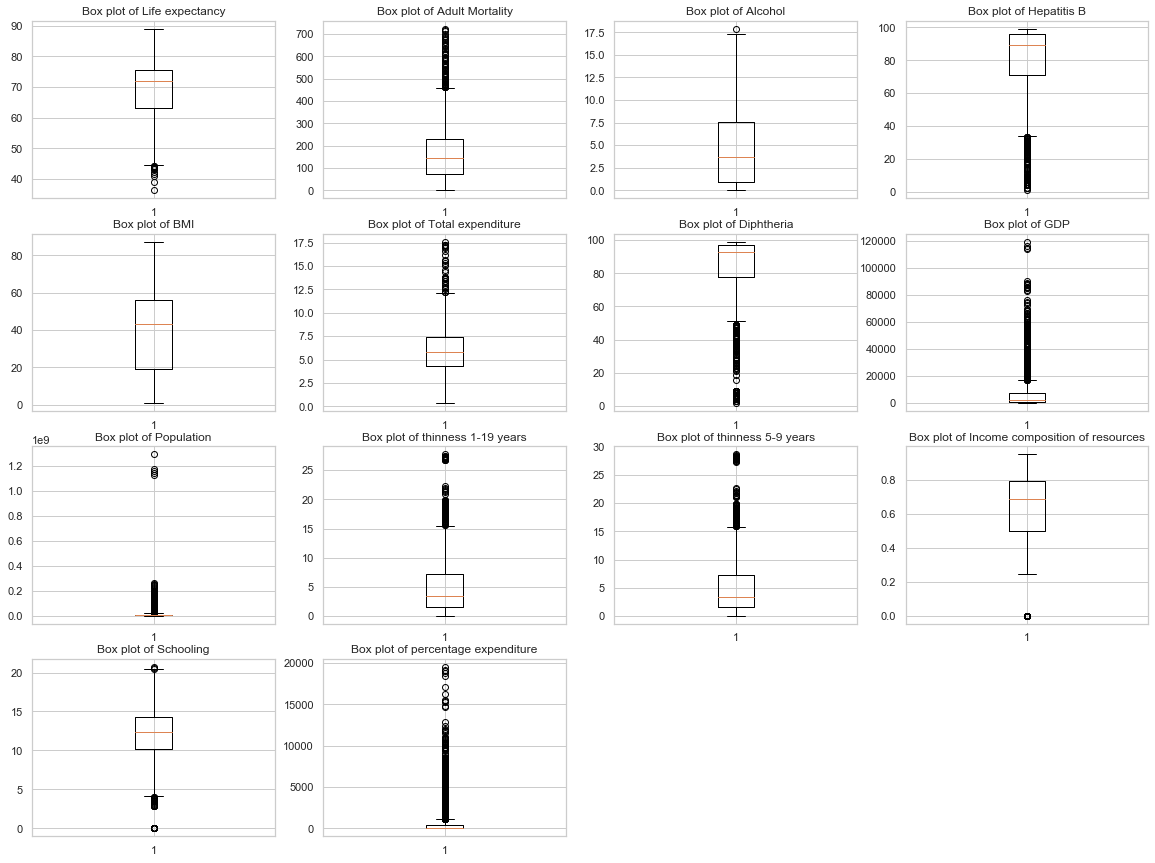

In [17]:
plt.figure(figsize = (20,15))

plt.subplot(4,4,1)
plt.boxplot(life_df['Life expectancy'])
plt.title("Box plot of Life expectancy")

plt.subplot(4,4,2)
plt.boxplot(life_df['Adult Mortality'])
plt.title("Box plot of Adult Mortality")

plt.subplot(4,4,3)
plt.boxplot(life_df['Alcohol'])
plt.title("Box plot of Alcohol")

plt.subplot(4,4,4)
plt.boxplot(life_df['Hepatitis B'])
plt.title("Box plot of Hepatitis B")

plt.subplot(4,4,5)
plt.boxplot(life_df['BMI'])
plt.title("Box plot of BMI")

plt.subplot(4,4,6)
plt.boxplot(life_df['Total expenditure'])
plt.title("Box plot of Total expenditure")

plt.subplot(4,4,7)
plt.boxplot(life_df['Diphtheria'])
plt.title("Box plot of Diphtheria")

plt.subplot(4,4,8)
plt.boxplot(life_df['GDP'])
plt.title("Box plot of GDP")

plt.subplot(4,4,9)
plt.boxplot(life_df['Population'])
plt.title("Box plot of Population")

plt.subplot(4,4,10)
plt.boxplot(life_df['thinness 1-19 years'])
plt.title("Box plot of thinness 1-19 years")

plt.subplot(4,4,11)
plt.boxplot(life_df['thinness 5-9 years'])
plt.title("Box plot of thinness 5-9 years")

plt.subplot(4,4,12)
plt.boxplot(life_df['Income composition of resources'])
plt.title("Box plot of Income composition of resources")

plt.subplot(4,4,13)
plt.boxplot(life_df['Schooling'])
plt.title("Box plot of Schooling")

plt.subplot(4,4,14)
plt.boxplot(life_df['percentage expenditure'])
plt.title("Box plot of percentage expenditure")

plt.show()

Boxplot visualization of outliers.

## Outlier Treatment

In [18]:
upper_out = ['Adult Mortality', 'Total expenditure', 'GDP', 'Population', 'thinness 1-19 years',
             'thinness 5-9 years', 'percentage expenditure']

lower_out = ['Life expectancy', 'Hepatitis B', 'Diphtheria', 'Schooling']

for col in upper_out:
    life_df[col] = winsorize(life_df[col], (0, 0.05))

for col in lower_out:
    life_df[col] = winsorize(life_df[col], (0.10, 0))

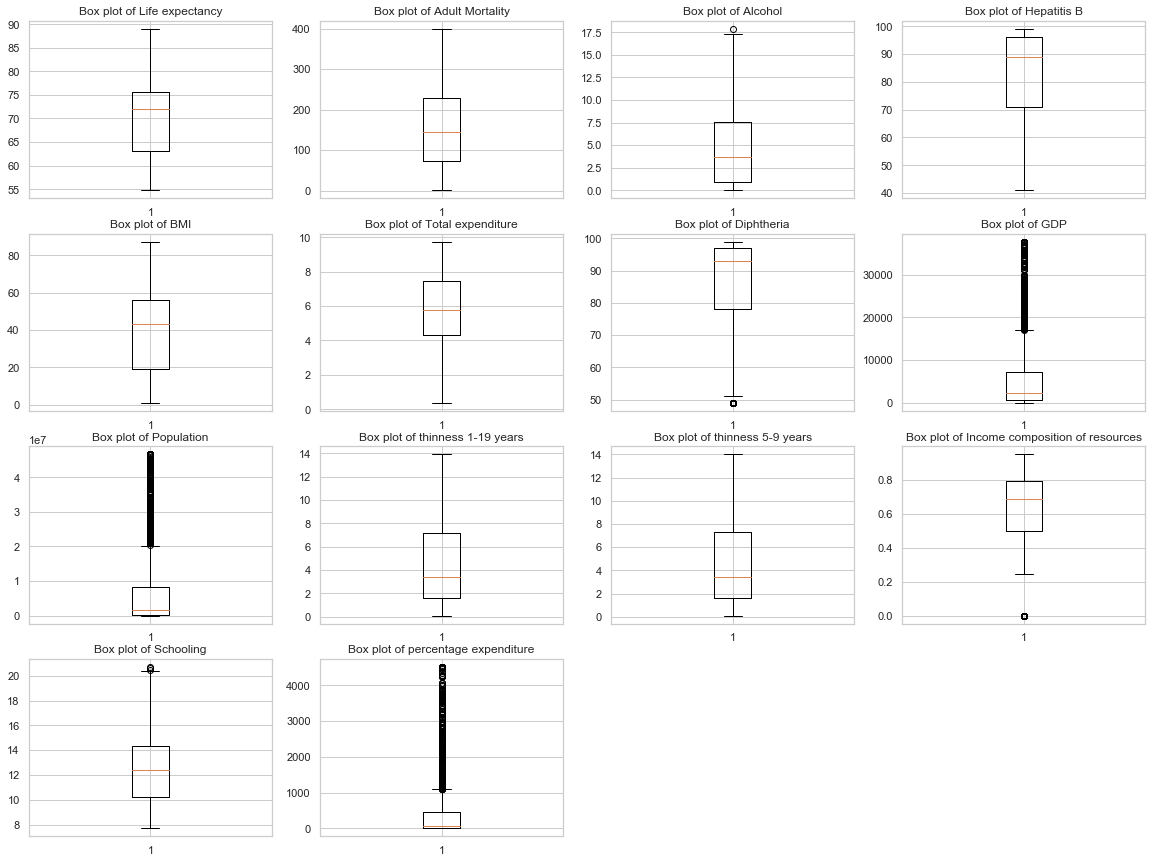

In [19]:
plt.figure(figsize = (20,15))

plt.subplot(4,4,1)
plt.boxplot(life_df['Life expectancy'])
plt.title("Box plot of Life expectancy")

plt.subplot(4,4,2)
plt.boxplot(life_df['Adult Mortality'])
plt.title("Box plot of Adult Mortality")

plt.subplot(4,4,3)
plt.boxplot(life_df['Alcohol'])
plt.title("Box plot of Alcohol")

plt.subplot(4,4,4)
plt.boxplot(life_df['Hepatitis B'])
plt.title("Box plot of Hepatitis B")

plt.subplot(4,4,5)
plt.boxplot(life_df['BMI'])
plt.title("Box plot of BMI")

plt.subplot(4,4,6)
plt.boxplot(life_df['Total expenditure'])
plt.title("Box plot of Total expenditure")

plt.subplot(4,4,7)
plt.boxplot(life_df['Diphtheria'])
plt.title("Box plot of Diphtheria")

plt.subplot(4,4,8)
plt.boxplot(life_df['GDP'])
plt.title("Box plot of GDP")

plt.subplot(4,4,9)
plt.boxplot(life_df['Population'])
plt.title("Box plot of Population")

plt.subplot(4,4,10)
plt.boxplot(life_df['thinness 1-19 years'])
plt.title("Box plot of thinness 1-19 years")

plt.subplot(4,4,11)
plt.boxplot(life_df['thinness 5-9 years'])
plt.title("Box plot of thinness 5-9 years")

plt.subplot(4,4,12)
plt.boxplot(life_df['Income composition of resources'])
plt.title("Box plot of Income composition of resources")

plt.subplot(4,4,13)
plt.boxplot(life_df['Schooling'])
plt.title("Box plot of Schooling")

plt.subplot(4,4,14)
plt.boxplot(life_df['percentage expenditure'])
plt.title("Box plot of percentage expenditure")

plt.show()

Most outliers have been dealt with, and the variable that remain with high numbers of outliers will not be used as features anyway (analysis below), so we will move on.

## Univariate analysis

In [20]:
life_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.666440,159.665248,30.303948,4.548919,554.389171,80.946645,2419.592240,38.29869,42.035739,5.840851,85.118740,1.742103,6594.371266,7.610291e+06,4.687969,4.704700,0.634458,12.301250
std,4.613841,8.607764,110.245123,117.926501,3.994854,1138.549608,19.371200,11467.272489,19.99140,160.445548,2.197031,15.963752,5.077785,10042.892082,1.263197e+07,3.823343,3.853879,0.209574,2.863299
min,2000.000000,54.800000,1.000000,0.000000,0.010000,0.000000,41.035714,0.000000,1.00000,0.000000,0.370000,49.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,7.700000
25%,2004.000000,63.100000,74.000000,0.000000,0.902500,4.685343,71.000000,0.000000,19.32500,0.000000,4.312500,78.000000,0.100000,553.618620,2.536025e+05,1.600000,1.600000,0.500000,10.200000
50%,2008.000000,72.000000,144.000000,3.000000,3.697500,64.912906,89.000000,17.000000,43.25000,4.000000,5.760000,93.000000,0.100000,2192.681084,1.576319e+06,3.400000,3.400000,0.684000,12.400000
75%,2012.000000,75.600000,228.000000,22.000000,7.550000,441.534144,96.000000,360.250000,56.10000,28.000000,7.440000,97.000000,0.800000,7183.381694,8.215738e+06,7.200000,7.300000,0.791107,14.300000
max,2015.000000,89.000000,399.000000,1800.000000,17.870000,4508.806185,99.000000,212183.000000,87.30000,2500.000000,9.750000,99.000000,50.600000,37698.785730,4.662799e+07,13.900000,14.000000,0.948000,20.700000


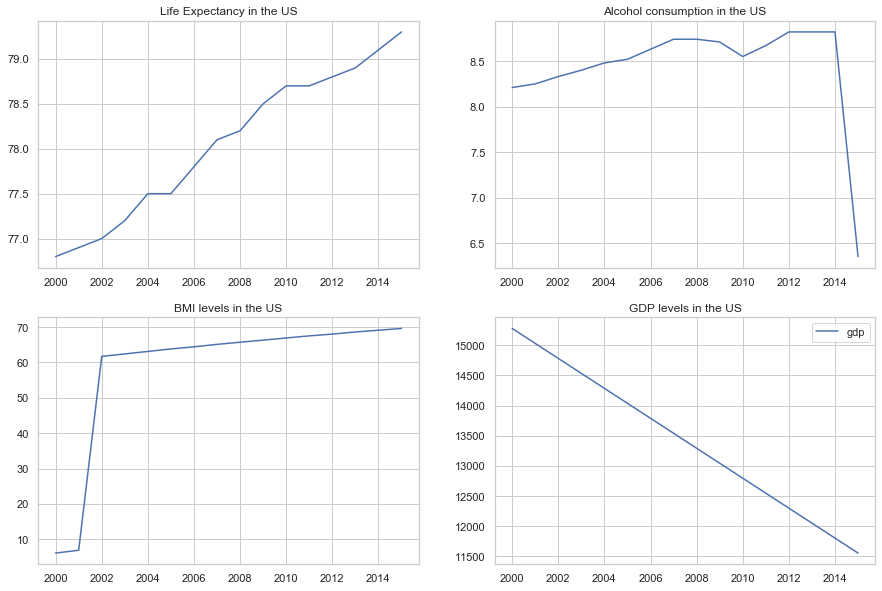

In [21]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(life_df.loc[life_df['Country'] == 'United States of America', 'Year'],
        life_df.loc[life_df['Country'] == 'United States of America', 'Life expectancy'], label='life expectancy')
plt.title('Life Expectancy in the US')

plt.subplot(222)
plt.plot(life_df.loc[life_df['Country'] == 'United States of America', 'Year'],
        life_df.loc[life_df['Country'] == 'United States of America', 'Alcohol'], label='alcohol')
plt.title('Alcohol consumption in the US')

plt.subplot(223)
plt.plot(life_df.loc[life_df['Country'] == 'United States of America', 'Year'],
        life_df.loc[life_df['Country'] == 'United States of America', 'BMI'], label='bmi')
plt.title('BMI levels in the US')

plt.subplot(224)
plt.plot(life_df.loc[life_df['Country'] == 'United States of America', 'Year'],
        life_df.loc[life_df['Country'] == 'United States of America', 'GDP'], label='gdp')
plt.title('GDP levels in the US')

plt.legend()
plt.show()

Strong shifts may be the effect of the generalized interpolation we had to do.

In [22]:
# combining variables.

life_df['thinness'] = (life_df['thinness 5-9 years'] + life_df['thinness 1-19 years'])/2

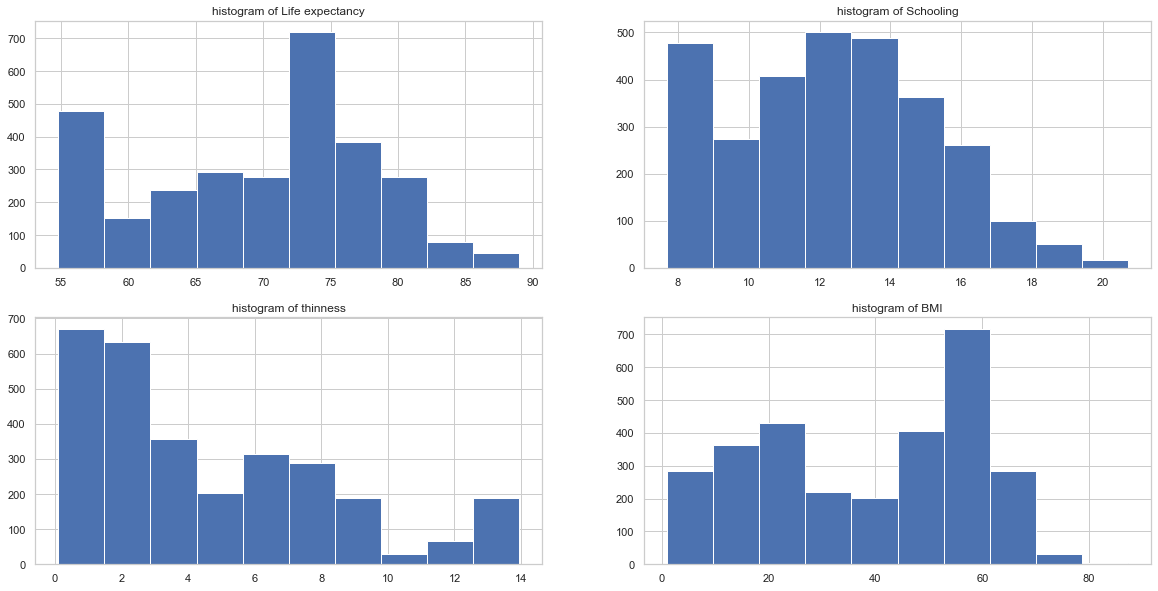

In [23]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.hist(life_df['Life expectancy'])
plt.title("histogram of {}".format("Life expectancy"))

plt.subplot(2,2,2)
plt.hist(life_df['Schooling'])
plt.title("histogram of {}".format("Schooling"))

plt.subplot(2,2,3)
plt.hist(life_df['thinness'])
plt.title("histogram of {}".format("thinness"))

plt.subplot(2,2,4)
plt.hist(life_df['BMI'])
plt.title("histogram of {}".format('BMI'))
plt.show()

No normal distributions. Will apply boxcox to approximate variables to a normal distribution for use with specific machine learning models.

In [24]:
from scipy.stats import boxcox

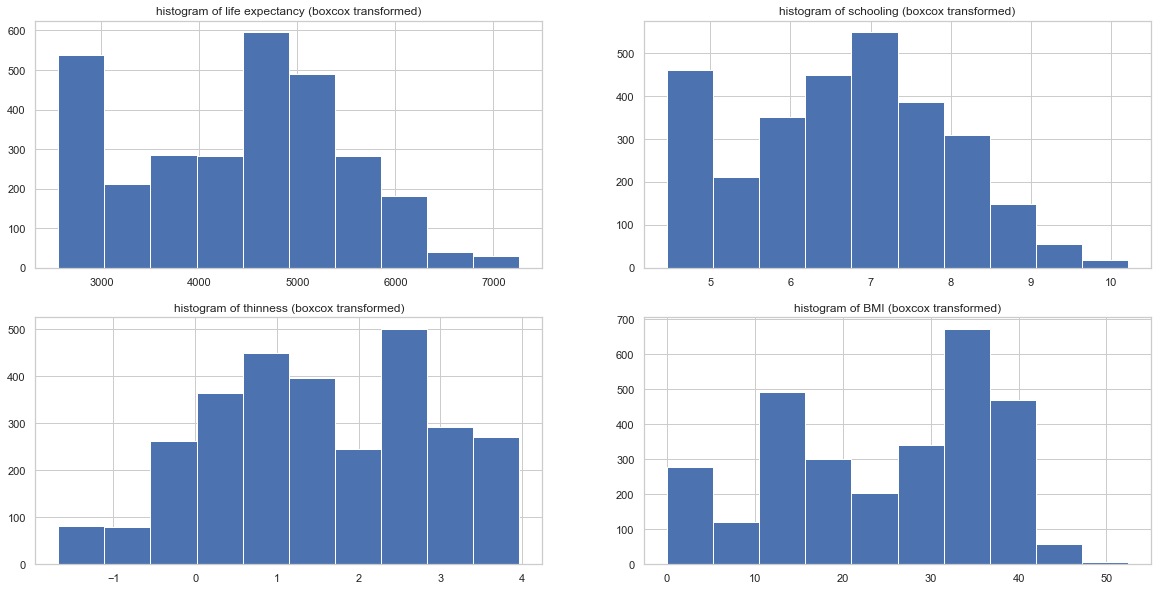

In [25]:
life_boxcox,_ = boxcox(life_df['Life expectancy'])
thinness_boxcox,_ = boxcox(life_df['thinness'])
schooling_boxcox,_ = boxcox(life_df['Schooling'])
bmi_boxcox,_ = boxcox(life_df['BMI'])

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.hist(life_boxcox)
plt.title("histogram of life expectancy (boxcox transformed)")

plt.subplot(2,2,2)
plt.hist(schooling_boxcox)
plt.title('histogram of schooling (boxcox transformed)')

plt.subplot(2,2,3)
plt.hist(thinness_boxcox)
plt.title('histogram of thinness (boxcox transformed)')

plt.subplot(2,2,4)
plt.hist(bmi_boxcox)
plt.title('histogram of BMI (boxcox transformed)')

plt.show()

The variables now look more normally distributed but not perfectly so. Let's confirm with a jarque bera and normality test.

In [26]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [27]:
jb_stats = jarque_bera(life_boxcox)
norm_stats = normaltest(life_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(schooling_boxcox)
norm_stats = normaltest(schooling_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(thinness_boxcox)
norm_stats = normaltest(thinness_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(bmi_boxcox)
norm_stats = normaltest(bmi_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 79.9683384195411 and p value is 0.0
Normality test statistics is 238.4026874001768 and p value is 1.704175022047886e-52
Jarque-Bera test statistics is 59.33119040055834 and p value is 1.3078427230084344e-13
Normality test statistics is 147.53804565601766 and p value is 9.173191298187285e-33
Jarque-Bera test statistics is 81.49368316549204 and p value is 0.0
Normality test statistics is 249.40076641844567 and p value is 6.97126642935983e-55
Jarque-Bera test statistics is 223.7785928264576 and p value is 0.0
Normality test statistics is 2285.7832984580114 and p value is 0.0


P value indicates variables are still not normally distributed. This will factor in to our decision of what machine learning model to eventually use.

## Multivariate Analysis

In [28]:
life_df.groupby('Status').mean()[['Life expectancy', 'Schooling', 'Alcohol']]

,Life expectancy,Schooling,Alcohol
Status,,,
Developed,79.197852,15.640031,9.634141
Developing,67.654864,11.596610,3.475699


In [29]:


life_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,thinness
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,8.16,65.0,0.1,584.259210,33736494.0,13.9,14.0,0.479,10.1,13.95
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,8.18,62.0,0.1,612.696514,327582.0,13.9,14.0,0.476,10.0,13.95
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,8.13,64.0,0.1,631.744976,31731688.0,13.9,14.0,0.470,9.9,13.95
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,8.52,67.0,0.1,669.959000,3696958.0,13.9,14.0,0.463,9.8,13.95
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,7.87,68.0,0.1,63.537231,2978599.0,13.9,14.0,0.454,9.5,13.95


In [30]:
corrmat_life = life_df[['Life expectancy', 'Alcohol', 'GDP', 'BMI',
         'Hepatitis B', 'Measles', 'Polio', 'Diphtheria',
         'Total expenditure', 'HIV/AIDS', 'Schooling',
         'Income composition of resources', 'thinness']].corr()


corrmat_life

,Life expectancy,Alcohol,GDP,BMI,Hepatitis B,Measles,Diphtheria,Total expenditure,HIV/AIDS,Schooling,Income composition of resources,thinness
Life expectancy,1.000000,0.427124,0.498408,0.566803,0.292098,-0.149332,0.570668,0.243486,-0.492670,0.749532,0.701784,-0.562713
Alcohol,0.427124,1.000000,0.378493,0.319618,0.107213,-0.050497,0.269493,0.304010,-0.048190,0.543812,0.442169,-0.445820
GDP,0.498408,0.378493,1.000000,0.298585,0.051990,-0.073548,0.251935,0.132124,-0.151934,0.520610,0.482161,-0.346276
BMI,0.566803,0.319618,0.298585,1.000000,0.200854,-0.175347,0.337156,0.229264,-0.243181,0.523431,0.461457,-0.574175
Hepatitis B,0.292098,0.107213,0.051990,0.200854,1.000000,-0.135426,0.601309,0.116534,-0.128738,0.256851,0.239498,-0.157560
Measles,-0.149332,-0.050497,-0.073548,-0.175347,-0.135426,1.000000,-0.165395,-0.106312,0.030899,-0.089900,-0.087650,0.183898
Diphtheria,0.570668,0.269493,0.251935,0.337156,0.601309,-0.165395,1.000000,0.174884,-0.200511,0.478596,0.445634,-0.304846
Total expenditure,0.243486,0.304010,0.132124,0.229264,0.116534,-0.106312,0.174884,1.000000,0.006583,0.269749,0.165986,-0.306324
HIV/AIDS,-0.492670,-0.048190,-0.151934,-0.243181,-0.128738,0.030899,-0.200511,0.006583,1.000000,-0.241012,-0.246793,0.252165
Schooling,0.749532,0.543812,0.520610,0.523431,0.256851,-0.089900,0.478596,0.269749,-0.241012,1.000000,0.783559,-0.533654


Text(0.5, 1, 'correlation matrix (Life_df)')

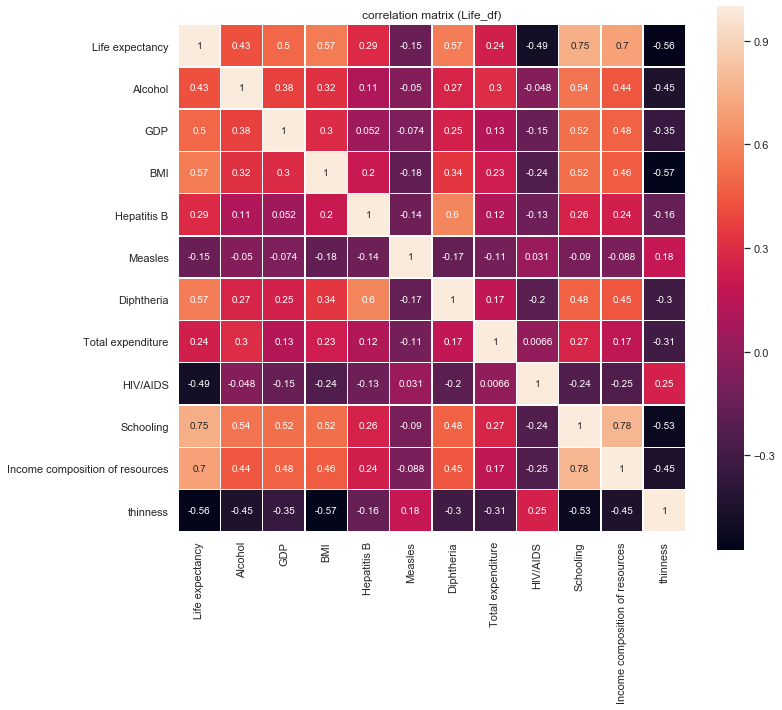

In [31]:
plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_life, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Life_df)")

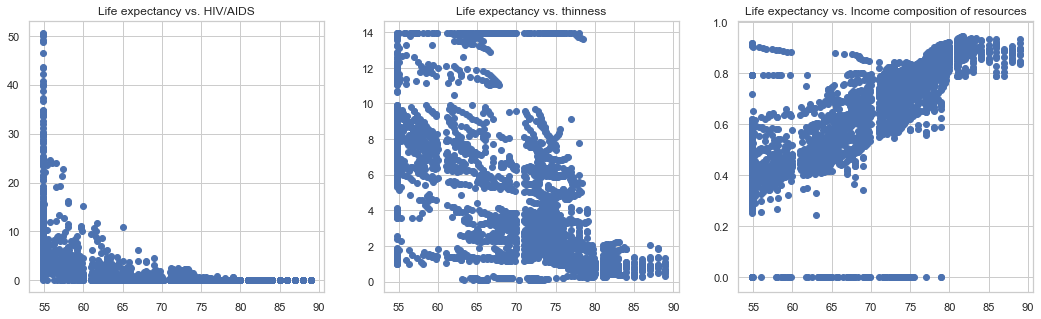

In [32]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(life_df['Life expectancy'], life_df["HIV/AIDS"])
plt.title("Life expectancy vs. HIV/AIDS")

plt.subplot(1,3,2)
plt.scatter(life_df['Life expectancy'], life_df["thinness"])
plt.title("Life expectancy vs. thinness")

plt.subplot(1,3,3)
plt.scatter(life_df['Life expectancy'], life_df["Income composition of resources"])
plt.title("Life expectancy vs. Income composition of resources")

plt.show()

Noting the presence of outlier value pairs. If needed, they could also be treated.

## Summary of findings & Feature Engineering Selections

The main way to improve this dataset would be to fill out missing values more accurately. It would spare us volatile readings of certain variables, like the line plots done for the US above. After discussing potential methods with my mentor and two technical coaches, I understood these methods were outside the scope of this challenge, but will keep them in mind for future reference.

The data displayed outliers for all variables, which I treated using winsorization.

The histograms for the variables mentioned above show their data is not normally distributed even after a boxcox transformation, which would inform our decision of what machine learning model to use. Our scatterplot of some of these variables against life expectancy clearly reveals outlier value pairs, which could also be treated if necessary.

As seen in the heatmap above, some of the variables which correlate most strongly with life expectancy are schooling, thinness, BMI and income composition of resources. These variables also have varying levels of correlation between each other, which would need to be considered for applying techniques like PCA.

Finally, in terms of feature engineering, I decided to combine the 'thinness 5-9' and 'thinness 10-19' variables into a single averaged one due to the similarity of what they measured as well as to their identical correlations. No weighting was needed to do this because they contain the same number of values. Based on heatmap correlations of variables to life expectancy and also between those variables, the features I selected for the modeling phase are represented in the scatterplots above: HIV/AIDS, thinness, and income composition of resources. I believe this is a good balance of correlation to the target variable while maintaining relatively low correlation between each other.